In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# stdlib
import os
import shutil

# 3rd party
import ipyparallel as ipp
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# local
import kelp_analyze
import kelp_compute
import mms

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
sp.init_printing()
%matplotlib inline

---

## User-function definitions

In [4]:
def uniform_vsf(delta):
    return 1/(4*sp.pi)

In [5]:
def linear_vsf(delta):
    return 2/sp.pi * (1-delta)

In [6]:
# TODO: No upwelling light from bottom
# Also, spatially homogeneous BC
def prod_L(x, y, z, theta, phi, alpha, gamma):
    return (
        (
            (
                (2+sp.sin(2*sp.pi*x/alpha))
                *(2+sp.sin(2*sp.pi*y/alpha))
                *(sp.sin(sp.pi*z/gamma))
            ) + sp.exp(-z/gamma)
        )
        *(2+sp.sin(phi))
    )

In [7]:
def uniform_L(x, y, z, theta, phi, alpha, gamma):
    return alpha

In [8]:
def tanh_L(x, y, z, theta, phi, alpha, gamma):
    return alpha * sp.tanh(gamma-z)

In [9]:
def tanh_b_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha * sp.tanh(gamma-b*z) * (1+z*sp.sin(x)*sp.sin(y))

In [10]:
# TODO: Should be periodic on correct grid
def prod_a(x, y, z):
    return (2+sp.sin(2*sp.pi*x))*(2+sp.sin(2*sp.pi*y))*(1+sp.tanh(z-gamma))

In [11]:
def uniform_a(x, y, z):
    return 0.2

### Decide here which functions to use.

In [12]:
sol_func = tanh_b_L
abs_func = prod_a
vsf_func = linear_vsf

---

## Calculate source & BC

In [13]:
b = sp.var('b')
params = sp.var('b, alpha, gamma')

source_expr = mms.calculate_source(sol_func, b, abs_func, vsf_func, params)
bc_expr = mms.calculate_bc(sol_func, params)

# Evaluate other expressions as well for consistency
sol_expr = sol_func(*mms.space, *mms.angle, *params)
abs_expr = abs_func(*mms.space)
vsf_expr = vsf_func(mms.delta)

## Specify parameter values

In [14]:
alpha = 1
gamma = 1
b = 0.2
param_vals = {
    'alpha': alpha,
    'gamma': gamma,
    'b': b
}

# Domain size
rope_spacing = 1
zmax = 1

## Generate symbolic and numerical functions

In [15]:
# Generate symbolic functions
source_sym = mms.symify(source_expr, *mms.space, *mms.angle, **param_vals)
abs_sym = mms.symify(abs_expr, *mms.space, **param_vals)
bc_sym = mms.symify(bc_expr, *mms.angle, **param_vals)
vsf_sym = mms.symify(vsf_expr, mms.delta, **param_vals)
sol_sym = mms.symify(sol_expr, *mms.space, *mms.angle, **param_vals)

# Generate numerical functions
abs_func_N = kelp_compute.sym_to_num(abs_sym, *mms.space)
source_func_N = kelp_compute.sym_to_num(source_sym, *mms.space, *mms.angle)
bc_func_N = kelp_compute.sym_to_num(bc_sym, *mms.angle)
vsf_func_N = kelp_compute.sym_to_num(vsf_sym, mms.delta)
sol_func_N = kelp_compute.sym_to_num(sol_sym, *mms.space, *mms.angle)

## Problem Summary

In [16]:
print("Solution")
mms.display_eq('L', sol_expr)
print()

print("Absorption Coefficient")
mms.display_eq('a', abs_expr)
print()

print("VSF")
mms.display_eq('beta', vsf_expr)

print("Boundary Condition")
mms.display_eq('L_0', bc_expr)
print()

print("Source")
mms.display_eq('sigma', source_expr)
print()

Solution



Absorption Coefficient



VSF


Boundary Condition



Source


## Check solution constraints

- Everything is periodic in x, y
- Absorption coefficient is positive
- Boundary condition depends only on angle
- No upwelling light from below

## Check source term

Source term seems too high, so try substituting parameters,
then plugging in analytical solution.

The result should be 0.

In [17]:
diff = mms.check_sol(sol_sym, b, abs_sym, vsf_sym, source_sym)
diff

In [18]:
num_diff = sp.lambdify(
    (*mms.space, *mms.angle),
    diff,
    modules=("numpy",)
)

In [19]:
# Check numerical max on grid in case of numerical error in above expression
np.max(num_diff(*mms.gen_grid(10, 10, 10, 10, 1, 1)))

0

## Code Verification Study

In [21]:
#remote_config = kelp_param.ParamSpanRemoteConfig()
ipc = ipp.Client()
lv = ipc.load_balanced_view()
dv = ipc.direct_view()
print(ipc.ids)

[0, 1, 2, 3]


In [29]:
ipc.queue_status()

{'unassigned': 0,
 0: {'queue': 0, 'completed': 3, 'tasks': 0},
 1: {'queue': 0, 'completed': 7, 'tasks': 0},
 2: {'queue': 0, 'completed': 4, 'tasks': 0},
 3: {'queue': 0, 'completed': 3, 'tasks': 0}}

In [23]:
# Set parameters
study_name = 'verify_test_20'
kelp_dist='top-heavy'

ns_max = 20
nz_max = 20
ntheta_max = 20
nphi_max = 20

ns_list = range(4, ns_max+1, 4)
nz_list = range(4, nz_max+1, 4)
ntheta_list = range(4, ntheta_max+1, 4)
nphi_list = range(4, nphi_max+1, 4)

# ns_list = [10]
# nz_list = [10]
# ntheta_list = [10]
# nphi_list = [10]

base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
#base_dir = '/home/oliver/academic/research/kelp-results'

# TODO: Don't actually delete results
# shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

combine_thread, gs_fut = kelp_compute.fd_verify_compute(
    study_name, 
    ns_list, nz_list, ntheta_list, nphi_list, 
    rope_spacing, zmax, b, 
    sol_expr, abs_expr, source_expr, bc_expr, vsf_expr, 
    param_vals, base_dir=base_dir)

Creating new study directory.
Running grid (20,20,20,20)
Running grid ( 4,20,20,20)
Running grid ( 8,20,20,20)
Running grid (12,20,20,20)
Running grid (16,20,20,20)
Running grid (20, 4,20,20)
Running grid (20, 8,20,20)
Running grid (20,12,20,20)
Running grid (20,16,20,20)
Running grid (20,20, 4,20)
Running grid (20,20, 8,20)
Running grid (20,20,12,20)
Running grid (20,20,16,20)
Running grid (20,20,20, 4)
Running grid (20,20,20, 8)
Running grid (20,20,20,12)
Running grid (20,20,20,16)
Reading existing runs.
Finished reading existing runs.
Calling solve_rte_with_callbacks(20, 20, 20, 20, 1, 1, 0.2, alpha*(z*sin(x)*sin(y) + 1)*tanh(-b*z + gamma), (sin(2*pi*x) + 2)*(sin(2*pi*y) + 2)*(tanh(-gamma + z) + 1), alpha*z*sin(phi)*sin(theta)*sin(x)*cos(y)*tanh(-b*z + gamma) + alpha*z*sin(phi)*sin(y)*cos(theta)*cos(x)*tanh(-b*z + gamma) + alpha*(b + (sin(2*pi*x) + 2)*(sin(2*pi*y) + 2)*(tanh(-gamma + z) + 1))*(z*sin(x)*sin(y) + 1)*tanh(-b*z + gamma) - b*(2*alpha*(pi*sin(phi)*sin(theta)/2 + 2*pi)*(z*

## Analyze convergece

In [30]:
import sqlite3

In [31]:
study_dir = os.path.join(base_dir, study_name)
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

In [32]:
len(kelp_analyze.query_results(conn, study_name, ns=8, nz=12, ntheta=12, nphi=12))

In [33]:
from scipy.optimize import minimize

In [34]:
def lin_fit(x, y, x0, x1):
    x_arr = np.array(x)
    y_arr = np.array(y)
    which_inds = np.logical_and(
        x_arr>=x0,
        x_arr<=x1
    )
    x_fit = x_arr[which_inds]
    y_fit = y_arr[which_inds]
    
    def resid(args):
        m, b = args
        res = np.sum((m*x_fit + b - y_fit) ** 2)
        return res
    
    m0 = 1
    b0 = 0
    res = minimize(resid, (m0, b0))
    m, b = res.x
    
    return m, b

In [36]:
def plot_lin_fit(x, y, x0, x1, xlabel='x', ylabel='y'):
    xmin = np.min(x)
    ymin = np.min(y)
    xmax = np.max(x)
    ymax = np.max(y)
    
    plt.plot(x, y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.vlines((x0, x1), ymin, ymax, colors='k', linestyles='dashed')
    
    m, b = lin_fit(x, y, x0, x1)
    label = 'm={:.2f}, b={:.2f}'.format(m, b)
    plt.plot([xmin, xmax], [m*xmin + b, m*xmax + b], '--')
    plt.title(label)
    plt.show()

In [37]:
import run_utils as ru

### Dumb way

ns
err 4: 0.5009283917553669
err 8: 0.4920352636425259
err 12: 0.4901800513738338
err 16: 0.4895524489173852
err 20: 0.4892662971845342


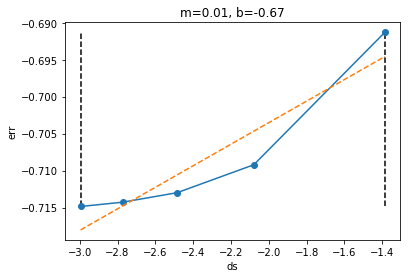

nz
err 4: 0.486993219047987
err 8: 0.4886428148420928
err 12: 0.489040047296403
err 16: 0.4891944307579822
err 20: 0.4892662971845342


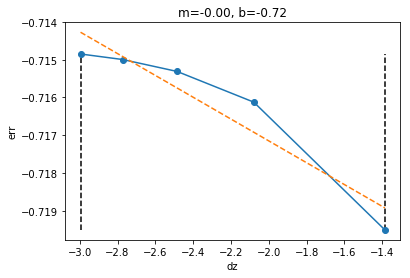

ntheta
err 4: 0.5026873242336349
err 8: 0.49170964740681083
err 12: 0.48982942087496634
err 16: 0.48940544571582545
err 20: 0.4892662971845342


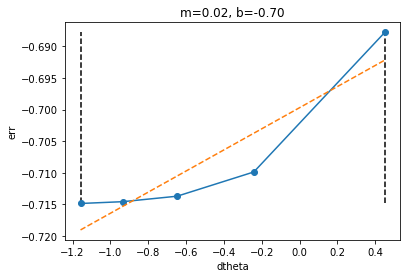

nphi
err 4: 0.48033440736723093
err 8: 0.48857645393036175
err 12: 0.48929579502605736
err 16: 0.4893361863387271
err 20: 0.4892662971845342


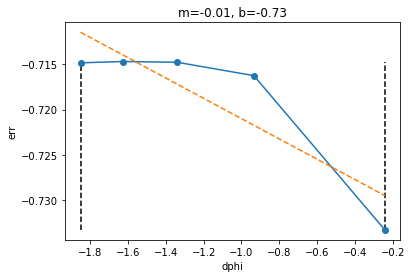

In [39]:
# Regular L2 norm
norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
# Make norm independent of vector size
norm = lambda x: np.sqrt(np.sum(x**2)/np.size(x))
# Arithmetic mean
# norm = lambda x: np.sum(np.abs(x))/np.size(x)

# ns
print("ns")
err_dict = {}
for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns, nz=nz_max, ntheta=ntheta_max, nphi=nphi_max
    )
    
    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    
    err = norm(rad - true_rad)
    print("err {}: {}".format(ns, err))
    err_dict[ns] = err

res_arr = rope_spacing / np.array(ns_list)
err_arr = np.array([err_dict[ns] for ns in ns_list])

plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr)), max(np.log(res_arr)), 
    xlabel='ds', ylabel='err'
)

# nz
print("nz")
err_dict = {}
for nz in nz_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns_max, nz=nz, ntheta=ntheta_max, nphi=nphi_max
    )
    
    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    
    err = norm(rad - true_rad)
    print("err {}: {}".format(nz, err))
    err_dict[nz] = err

res_arr = zmax / np.array(nz_list)
err_arr = np.array([err_dict[nz] for nz in nz_list])

plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr)), max(np.log(res_arr)), 
    xlabel='dz', ylabel='err'
)

# ntheta
print("ntheta")
err_dict = {}
for ntheta in ntheta_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns_max, nz=nz_max, ntheta=ntheta, nphi=nphi_max
    )
    
    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    
    err = norm(rad - true_rad)
    print("err {}: {}".format(ntheta, err))
    err_dict[ntheta] = err

res_arr = 2*np.pi / np.array(ntheta_list)
err_arr = np.array([err_dict[ntheta] for ntheta in ntheta_list])

plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr)), max(np.log(res_arr)), 
    xlabel='dtheta', ylabel='err'
)

# nphi
print("nphi")
err_dict = {}
for nphi in nphi_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns_max, nz=nz_max, ntheta=ntheta_max, nphi=nphi
    )
    
    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    
    err = norm(rad - true_rad)
    print("err {}: {}".format(nphi, err))
    err_dict[nphi] = err

res_arr = np.pi / np.array(nphi_list)
err_arr = np.array([err_dict[nphi] for nphi in nphi_list])

plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr)), max(np.log(res_arr)), 
    xlabel='dphi', ylabel='err'
)

In [ ]:
1/0

### Test values

In [40]:
import ipyvolume as ipv

In [41]:
import ipywidgets as ipw

In [42]:
import discrete_plot

In [43]:
import run_utils as ru

In [44]:
from fortran_wrappers.light_utils_wrap import light_utils_wrap as lu

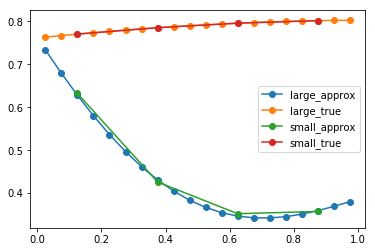

In [48]:
ns = 20
nz = 20
ntheta = 20
nphi = 20
grid = mms.gen_grid(ns, nz, ntheta, nphi, rope_spacing, zmax)
x, y, z, _, _ = grid
x1 = x[:,0,0,0]
y1 = y[0,:,0,0]
z1 = z[0,0,:,0]
results_list = kelp_analyze.query_results(
    conn, study_name, 
    ns=ns, nz=nz, ntheta=ntheta, nphi=nphi
)
large_approx_rad = results_list[0]['rad'][:]
large_approx_irrad = results_list[0]['irrad'][:]
large_true_rad = results_list[0]['true_rad'][:]
large_true_irrad = np.asfortranarray(np.zeros_like(large_approx_irrad))
lu.calculate_irradiance(large_true_rad, large_true_irrad, ntheta, nphi)

ns = 20
nz = 4
ntheta = 20
nphi = 20
grid = mms.gen_grid(ns, nz, ntheta, nphi, rope_spacing, zmax)
x, y, z, _, _ = grid
x2 = x[:,0,0,0]
y2 = y[0,:,0,0]
z2 = z[0,0,:,0]
results_list = kelp_analyze.query_results(
    conn, study_name, 
    ns=ns, nz=nz, ntheta=ntheta, nphi=nphi
)
small_approx_rad = results_list[0]['rad'][:]
small_approx_irrad = results_list[0]['irrad'][:]
small_true_rad = results_list[0]['true_rad'][:]
small_true_irrad = np.asfortranarray(np.zeros_like(small_approx_irrad))
lu.calculate_irradiance(small_true_rad, small_true_irrad, ntheta, nphi)

plt.plot(z1, large_approx_rad[0,0,:,0], 'o-', label='large_approx')
plt.plot(z1, large_true_rad[0,0,:,0], 'o-', label='large_true')

plt.plot(z2, small_approx_rad[0,0,:,0], 'o-', label='small_approx')
plt.plot(z2, small_true_rad[0,0,:,0], 'o-', label='small_true')
plt.legend()

                                     
#discrete_plot.volshow_zoom_correct_scale(x1, y1, z1, large_irrad, zoom_factor=3),
#discrete_plot.volshow_zoom_correct_scale(x2, y2, z2, small_irrad, zoom_factor=3)

In [52]:
results_list = kelp_analyze.query_results(
    conn, study_name, 
    ns=20, nz=20, ntheta=ntheta_max, nphi=nphi_max
)
irrad = results_list[0]['irrad'][:]
ipv.quickvolshow(irrad)

### Smart way

In [ ]:
norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = list(map(
    sorted,
    (ns_list, nz_list, ntheta_list, nphi_list)
))
max_res_list = list(map(
    max,
    (ns_list, nz_list, ntheta_list, nphi_list)
))
dim_dict = dict(zip(dim_names, dim_resolutions))

# One scatter before FD
num_scatters = 0
fd_flag = True

# Arguments which do not change between runs
const_args = (
    rope_spacing, zmax, b,
    sol_expr, abs_expr, source_expr, bc_expr, vsf_expr,
    param_dict, num_scatters, fd_flag
)

# Actual calling will be performed by decorator.
# Functions to be called
func_list = []
# Arguments to be passed
args_list = [] # iterables
kwargs_list = [] # dictionaries

# Run the largest grid once
ns, nz, ntheta, nphi = max_res_list
print("Running grid ({:2d},{:2d},{:2d},{:2d})".format(ns, nz, ntheta, nphi))
func_list.append(solve_rte_with_callbacks)
args_list.append((ns, nz, ntheta, nphi, *const_args))
kwargs_list.append({})

# Loop over dimensions
for dim_num, dim_name in enumerate(dim_names):
    # List of resolutions in the current dimension
    current_dim = dim_dict[dim_name]
    # Set all resolutions to their maximum values
    # Use [:] to just copy values and not modify list.
    current_res_list = max_res_list[:]

results_list = kelp_analyze.query_results(
    conn, study_name, 
    ns=ns, nz=nz_max, ntheta=ntheta_max, nphi=nphi_max
)

rad = results_list[0]['rad'][:]
true_rad = results_list[0]['true_rad'][:]

err = norm(rad - true_rad)
err_dict[ns] = err


    
# ns
print("ns")
err_dict = {}
for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns, nz=nz_max, ntheta=ntheta_max, nphi=nphi_max
    )
    
    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    
    err = norm(rad - true_rad)
    err_dict[ns] = err

res_arr = rope_spacing / np.array(ns_list)
err_arr = np.array([err_dict[ns] for ns in ns_list])

plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr)), max(np.log(res_arr)), 
    xlabel='ds', ylabel='err'
)

# nz
print("nz")
err_dict = {}
for nz in nz_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns_max, nz=nz, ntheta=ntheta_max, nphi=nphi_max
    )
    
    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    
    err = norm(rad - true_rad)
    err_dict[nz] = err

res_arr = zmax / np.array(nz_list)
err_arr = np.array([err_dict[nz] for nz in nz_list])

plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr)), max(np.log(res_arr)), 
    xlabel='dz', ylabel='err'
)

# ntheta
print("ntheta")
err_dict = {}
for ntheta in ntheta_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns_max, nz=nz_max, ntheta=ntheta, nphi=nphi_max
    )
    
    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    
    err = norm(rad - true_rad)
    err_dict[ntheta] = err

res_arr = 2*np.pi / np.array(ntheta_list)
err_arr = np.array([err_dict[ntheta] for ntheta in ntheta_list])

plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr)), max(np.log(res_arr)), 
    xlabel='dtheta', ylabel='err'
)

# nphi
print("nphi")
err_dict = {}
for nphi in nphi_list:
    results_list = kelp_analyze.query_results(
        conn, study_name, 
        ns=ns_max, nz=nz_max, ntheta=ntheta_max, nphi=nphi
    )
    
    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    
    err = norm(rad - true_rad)
    err_dict[nphi] = err

res_arr = np.pi / np.array(nphi_list)
err_arr = np.array([err_dict[nphi] for nphi in nphi_list])

plot_lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr)), max(np.log(res_arr)), 
    xlabel='dphi', ylabel='err'
)

In [ ]:
print("hi")

In [ ]:
1/0

# Single-run

### Compute

In [ ]:
# Grid options
ns = 16
nz = 16
na = 10
nomega = na*(na-2) + 2

# Domain size
rope_spacing = 1
zmax = 1

# Solver options
lis_opts = "-i gmres -restart 100 -tol 1e-3"

# Set num_scatters
num_scatters_list = range(5)
max_num_scatters = max(num_scatters_list)

# Norm for error calculations
norm = lambda arr: np.linalg.norm(np.ravel(arr), ord=2)/np.size(arr)

# Numerical function for solution expansion
sol_expansion_N = mms.gen_series_N(sol_expr, max_num_scatters, **param_vals)

asymptotic_sol_dict = {}
sol_expansion_dict = {}
asymptotic_err_dict = {}
sol_expansion_err_dict = {}

for num_scatters in num_scatters_list:
    print("n={}".format(num_scatters))
    # Calculate asymptotic solution
    _, asymptotic_results = kelp_compute.solve_rte_with_callbacks_full(
        ns, nz, na,
        rope_spacing, zmax,
        b, abs_expr, source_expr, source_expansion_N, bc_expr, vsf_expr,
        param_dict, num_scatters=num_scatters, fd_flag=False, lis_opts=lis_opts
    )

    # Extract numerical solutions
    asymptotic_sol = asymptotic_results['rad']
    
    # Store results
    asymptotic_sol_dict[num_scatters] = asymptotic_sol
    
    # Evaluate true solution
    x, y, z, theta, phi = mms.gen_grid(ns, nz, na, rope_spacing, zmax)
    true_sol = sol_func_N(x, y, z, theta, phi)
    
    # Evaluate series expansion
    sol_expansion = np.zeros_like(asymptotic_sol)
    for n in range(num_scatters+1):
        sol_expansion += b**n * sol_expansion_N(x, y, z, theta, phi, n) 
    sol_expansion_dict[num_scatters] = sol_expansion
    
    # Calculate errors
    asymptotic_err = norm(asymptotic_sol-true_sol)
    asymptotic_err_dict[num_scatters] = asymptotic_err
    
    sol_expansion_err = norm(sol_expansion - true_sol)
    sol_expansion_err_dict[num_scatters] = sol_expansion_err

# Evaluate true solution on same grid
true_sol = sol_func_N(x, y, z, theta, phi)

In [ ]:
# Calculate finite difference solution
_, fd_results = kelp_compute.solve_rte_with_callbacks_full(
    ns, nz, na,
    rope_spacing, zmax,
    b, abs_sym, source_sym, source_expansion_N, bc_sym, vsf_sym,
    num_scatters=0, fd_flag=True, lis_opts=lis_opts
)

fd_sol = fd_results['rad']

fd_err = norm(fd_sol-true_sol)

### Plot

In [ ]:
# Pick one angle to evaluate symbolically and plot
l = 0
m = int(np.floor(na/4))

p = mms.p_hat(l, m, na)
th = theta[0,0,0,p]
ph = phi[0,0,0,p]

In [ ]:
plot_inds = np.zeros_like(true_sol, dtype=bool)
plot_inds[0,0,:,p] = True

plt.figure(figsize=(12,8))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

# Plot true solution
ax1.plot(z[plot_inds], true_sol[plot_inds], 'C0o-', label='true')

# Plot FD solution
ax1.plot(
    z[plot_inds],
    fd_sol[plot_inds], 
    'C1o-',
    label='FD'
)

# Plot FD error
ax2.plot(
    z[plot_inds], 
    -true_sol[plot_inds]+fd_sol[plot_inds], 
    'C1o-',
    label='FD'
)

ax3.plot(
    z[plot_inds], 
    np.abs(-true_sol[plot_inds]+fd_sol[plot_inds]), 
    'C1o-',
    label='FD'
)

for num_scatters in num_scatters_list:
    ax1.plot(
        z[plot_inds], 
        sol_expansion_dict[num_scatters][plot_inds], 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    ax1.plot(
        z[plot_inds], 
        asymptotic_sol_dict[num_scatters][plot_inds], 
        'C{}o--'.format(num_scatters+2)
    )
    
    # Plot true expansion error
    ax2.plot(
        z[plot_inds], 
        -true_sol[plot_inds]+sol_expansion_dict[num_scatters][plot_inds], 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    ax3.plot(
        z[plot_inds], 
        np.abs(-true_sol[plot_inds]+sol_expansion_dict[num_scatters][plot_inds]), 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    
    # Plot numerical asymptotics error
    ax2.plot(
        z[plot_inds], 
        -true_sol[plot_inds]+asymptotic_sol_dict[num_scatters][plot_inds], 
        'C{}o--'.format(num_scatters+2)
    )
    ax3.plot(
        z[plot_inds], 
        np.abs(-true_sol[plot_inds]+asymptotic_sol_dict[num_scatters][plot_inds]), 
        'C{}o--'.format(num_scatters+2)
    )
    
    
ax1.set_xlabel('z')
ax1.set_ylabel('rad')
ax1.legend()

ax2.set_xlabel('z')
ax2.set_ylabel('stripe diff')
ax2.set_yscale('linear')
ax2.legend()

ax3.set_xlabel('z')
ax3.set_ylabel('stripe err')
ax3.set_yscale('log')
ax3.legend()

# FD Error
ax4.hlines(fd_err, xmin=0, xmax=max_num_scatters, label='FD')

# Asymptotics error
ax4.plot(
    num_scatters_list, 
    [asymptotic_err_dict[n] for n in num_scatters_list],
    'o-',
    label='asym. err.'
)
# Expansion error
ax4.plot(
    num_scatters_list, 
    [sol_expansion_err_dict[n] for n in num_scatters_list],
    'o-',
    label='series err.'
)
ax4.set_xlabel('n')
ax4.set_ylabel('avg. tot. err.')
ax4.set_yscale('linear')
ax4.legend()